In [368]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import MeCab
import emoji as Emoji

In [369]:
from sequence import Sequence
from load_emojis import load_emojis

In [370]:
mecab = MeCab.Tagger("-Owakati")
wakati = mecab.parse("坂本ですが").split()
print(wakati)

['坂本', 'です', 'が']


In [522]:
def read_data():
  """Get data from MongoDB as a list of words"""
  #   with zipfile.ZipFile(filename) as f:
  #     data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  #   return data
  words = list()
  sequences = list()
  for sequence in Sequence.objects:
    words_in_sequence = mecab.parse(sequence.content).split()
    words.extend(words_in_sequence)
    sequences.append(words_in_sequence)
  return words, sequences
    
words, sequences = read_data()
print('Data size %d' % len(words))
print(words[:20])
print('Sequences size %d' % len(sequences))
print(sequences[:5])

Data size 489324
['筋', 'トレガンバ', '💪', '載せる', '😻', 'さき', 'な', 'おめでとう', '💓', '毎日', 'パイン', 'ジュース', '飲ん', 'でる', 'さき', 'な', 'ちゃん', 'たま', 'に', 'は']
Sequences size 62742
[['筋', 'トレガンバ', '💪'], ['載せる', '😻'], ['さき', 'な', 'おめでとう', '💓'], ['毎日', 'パイン', 'ジュース', '飲ん', 'でる', 'さき', 'な', 'ちゃん', 'たま', 'に', 'は', '惚気', '聞い', 'て', 'あげる', '😙'], ['結婚式', 'よん', 'で', 'ね', '☺', '️🍀']]


In [526]:
vocabulary_size = 30000

def build_dataset(words, sequences):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for sequence in sequences:
    data_in_sequence = list()
    for word in sequence:
      if word in dictionary:
        index = dictionary[word]
      else:
        index = 0  # dictionary['UNK']
        unk_count = unk_count + 1
      data_in_sequence.append(index)
    data.append(data_in_sequence)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words,sequences)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:5])
for sequence in data[:5]:
  print([reverse_dictionary[word] for word in sequence])
print(len(dictionary))
# for emoji in emojis[:10]:
#   print((emoji, dictionary[emoji]), end=", ")

# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 4039], ('て', 12645), ('た', 10637), ('の', 9063), ('に', 8063)]
Sample data [[4314, 22183, 300], [6394, 163], [1042, 10, 81, 30], [755, 7181, 2611, 1674, 740, 1042, 10, 35, 800, 4, 14, 2678, 652, 1, 840, 842], [2218, 1096, 11, 12, 92, 1779]]
['筋', 'トレガンバ', '💪']
['載せる', '😻']
['さき', 'な', 'おめでとう', '💓']
['毎日', 'パイン', 'ジュース', '飲ん', 'でる', 'さき', 'な', 'ちゃん', 'たま', 'に', 'は', '惚気', '聞い', 'て', 'あげる', '😙']
['結婚式', 'よん', 'で', 'ね', '☺', '️🍀']
30000


In [450]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
   """Similar to skip-gram but only apply for each sequence"""
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

IndentationError: unindent does not match any outer indentation level (<ipython-input-450-98221b518fcc>, line 5)

In [531]:
def generate_batch_in_sequence(sequence):
  """"num_skips = 2, skip_window = 1"""
  batch = list()
  labels = list()
  for i in range(1,len(sequence)-1):
#     buffer = [sequence[i-1:i+1]
    batch.extend([sequence[i], sequence[i]])
    labels.extend([sequence[i-1], sequence[i+1]])
  return batch, labels
#   for _ in range(span):
#     buffer.append(data[data_index])
#     data_index = (data_index + 1) % len(data)
#   for i in range(batch_size // num_skips):
#     target = skip_window  # target label at the center of the buffer
#     targets_to_avoid = [ skip_window ]
#     for j in range(num_skips):
#       while target in targets_to_avoid:
#         target = random.randint(0, span - 1)
#       targets_to_avoid.append(target)
#       batch[i * num_skips + j] = buffer[skip_window]
#       labels[i * num_skips + j, 0] = buffer[target]
#     buffer.append(data[data_index])
#     data_index = (data_index + 1) % len(data)
#   return batch, labels

# print('data:', [reverse_dictionary[di] for di in data[:8]])

# for num_skips, skip_window in [(2, 1), (4, 2)]:
#     data_index = 0
#     batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
#     print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
#     print('    batch:', [reverse_dictionary[bi] for bi in batch])
#     print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

seq = data[9]
batch, labels = generate_batch_in_sequence(seq)
print(seq)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels])

[676, 243, 11, 73, 0, 844, 2, 25]
    batch: ['最近', '最近', 'で', 'で', '1', '1', 'UNK', 'UNK', '使っ', '使っ', 'た', 'た']
    labels: ['ここ', 'で', '最近', '1', 'で', 'UNK', '1', '使っ', 'UNK', 'た', '使っ', '💭']


In [541]:
def generate_train(data):
  all_train_data = list()
  all_train_labels = list()
  for sequence in data:
    batch, labels = generate_batch_in_sequence(sequence)
    all_train_data.extend(batch)
    all_train_labels.extend(labels)
  return all_train_data, all_train_labels

all_train_data, all_train_labels = generate_train(data)

In [546]:
data_index = 0
def generate_batch(batch_size):
  global data_index
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  batch = all_train_data[data_index:data_index+batch_size]
  labels[:,0] = all_train_labels[data_index:data_index+batch_size]
  data_index = data_index + 1
  return batch, labels

batch, labels = generate_batch(8)
print(batch)
print(labels)

[22183, 22183, 10, 10, 81, 81, 7181, 7181]
[[4314]
 [ 300]
 [1042]
 [  81]
 [  10]
 [  30]
 [ 755]
 [2611]]


In [547]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
# valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = [dictionary[emoji] for emoji in emojis[:valid_size]]
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [435]:
# valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = [dictionary[emoji] for emoji in emojis[:valid_size]]
print(valid_examples)

[624, 102, 32, 532, 358, 186, 138, 110, 42, 207, 182, 80, 72, 882, 842, 267]


In [548]:
num_steps = 100001
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0

  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k): 
          if nearest[k] < len(reverse_dictionary):
            close_word = reverse_dictionary[nearest[k]]
          else:
           close_word = nearest[k]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.570962
Nearest to 😀: KANA, ゃねぇよっっ, エクステンデッド, 今後, 🐺👑, こい, 😑👍, ゟ,
Nearest to 😁: シャー, はなそ, ifyou, 💪💨, 🐻🍯, 球, びしばし, ˙༥˙,
Nearest to 😂: 一直線, 墓穴, 一昨日, 邸, かいせ, かっぱえびせん, 前田, 🍋,
Nearest to 😃: ゅかれたまぁん, おさらば, 💬🍃, ジヨン, 咦, ぷる, 9998, 👂🏻💞,
Nearest to 😄: ｳﾗﾔﾏ, 島崎, でかけ, 程よく, トライアングルワンピ, ズボン, 暑, 廻,
Nearest to 😅: BoccinoBar, ｽ, ネギ, 福神, 尽くす, たのしも, ｵｫｫ, 確保,
Nearest to 😆: ！〟, ぽん, 感謝, 👂🏻💞, 500, プチ, ジンギスカン, 被写体,
Nearest to 😉: 大河, 🙉💓, ˃˂💓, 💞🎂, 両手, 🙄💗, ふきん, アリガトーウ,
Nearest to 😊: ٚ˂̶॰, ☀⚡, 乃, 👶🏻💙, ！☁☁☁☁☁☁☁☁☁☁☁☁☁☁, 👑💓, 📚🍃, ヒーロー,
Nearest to 😋: ゎふゎでもない, 😤💨💨, 帰れる, 舛添, 思いっきり, でる, 💕💭👭, ぶさ,
Nearest to 😎: ベリー, ︎💚, 😤🌟, もらお, 😻💚, ‧, 植木, 詰める,
Nearest to 😍: 評判, ソコ, DisneySea, 🌷💗, にくく, 🎂🎉👏🏻🍰🎁💝, さりげ, エク,
Nearest to 😘: モニター, 😣💧, イベ, ぃがやさん, mappy, 内, ~~~。, 感,
Nearest to 😗: 賑やか, 🐠🐠🐠🐠, 😘🙌, ますみ, ひびき, ∂, つまみ食い, ふざけ,
Nearest to 😙: 海部, 目指せ, _-, イケメンアイドル, 😢😢💕💕💕, HappyBirthDay, 剤, もしかして,
Nearest to 😚: ｸﾞｰﾙ, ～～～✋, (´△｀), にて, tomelt, 🔥🔥🔥, 資格, 🙊💛,
Average loss at step 2000: 0.402690
Average loss at ste

In [555]:
num_points = 100

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

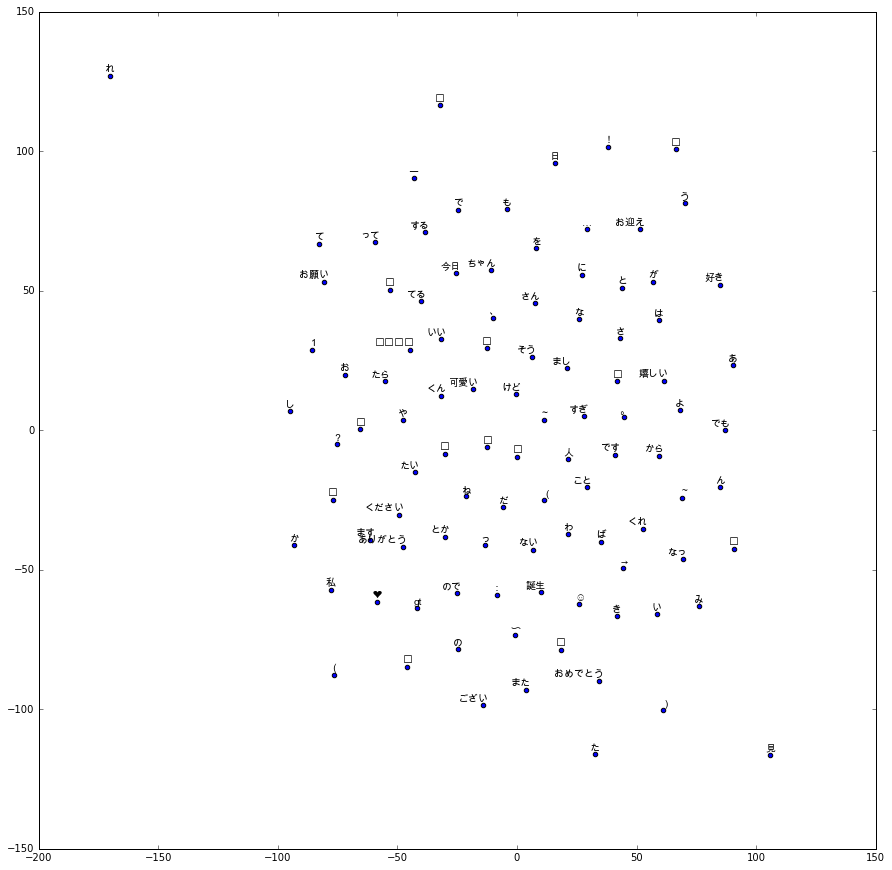

In [556]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='/Library/Fonts/Arial Unicode.ttf');
# matplotlib.rc('font', family='Arial Unicode')

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom', fontproperties = fp)
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)